In [1]:
# [START import]
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import numpy as np
# [END import]
import time
import pandas as pd
import progressbar
import pickle as pkl

In [2]:
# [START solution_printer]
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    # [END solution_printer]

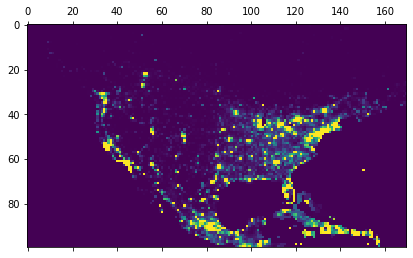

In [3]:
ascii_grid = np.loadtxt("/Users/shuffle_new/Desktop/Prelim/Modeling/Data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_2020_30_min_asc/gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_30_min.asc", skiprows=6)
order_density = ascii_grid
order_density[order_density == -9999] = 0
order_density[order_density > 200] = 200
order_density = order_density[50:150, 80:250]
plt.matshow(order_density)

In [4]:
x_len = np.shape(order_density)[0]
y_len = np.shape(order_density)[1]

In [5]:
N_depot = 3

# depot_loc_ls = np.array([[40,60, 90],[40,100,80]])
depot_loc_ls = np.array([[20,90, 40],[20,80,140]])

In [6]:
def create_data_model(order_loc_ls, depot_loc_ls, order_demands, capacity=150):
    
    node_loc_ls = np.concatenate((depot_loc_ls, order_loc_ls),axis=1)
    N_order = np.shape(order_loc_ls)[1]
    N_depot = np.shape(depot_loc_ls)[1]

    distance_matrix = np.zeros((N_order+N_depot, N_order+N_depot))

    for i in range(N_order+N_depot):
        for j in range(i+1, N_order+N_depot):
    #         print(i,j)
            distance_matrix[i,j] = np.linalg.norm([node_loc_ls[0,i]-node_loc_ls[0,j],node_loc_ls[1,i]-node_loc_ls[1,j]])
            distance_matrix[j,i] = distance_matrix[i,j]


    node_demands = np.concatenate((np.zeros(N_depot),order_demands))
    """Stores the data for the problem."""
    data = {}
    data['node_loc_ls'] = node_loc_ls
    data['distance_matrix'] = distance_matrix
    # [START demands_capacities]
    data['demands'] = node_demands
    
    N_vehicle_each_depot = 5

    data['num_vehicles'] = N_depot * N_vehicle_each_depot
    data['vehicle_capacities'] = np.ones(data['num_vehicles'])*capacity
    # [END demands_capacities]
    
#     data['depot'] = 0
    data['starts'] = [0,1,2]*N_vehicle_each_depot
    data['ends'] = [0,1,2]*N_vehicle_each_depot
    return data
    # [END data_model]
# plt.matshow(create_data_model(order_loc_ls, depot_loc_ls, order_demands)['distance_matrix'])


In [11]:
def vrp_solve(order_loc_ls, depot_loc_ls, order_demands, capacity):
    """Entry point of the program."""
    time_start = time.time()
    # Instantiate the data problem.
    data = create_data_model(order_loc_ls, depot_loc_ls, order_demands, capacity)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                        data['num_vehicles'], data['starts'],
                                        data['ends'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    # [START transit_callback]
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # [END transit_callback]

    # Define cost of each arc.
    # [START arc_cost]
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # [END arc_cost]

    # Add Capacity constraint.
    # [START capacity_constraint]
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # [END capacity_constraint]

    # Setting first solution heuristic.
    # [START parameters]
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # search_parameters.time_limit.seconds = 30
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)


    # search_parameters.local_search_metaheuristic = (
    #     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    # search_parameters.log_search = True
    # [END parameters]

    # Solve the problem.
    # [START solve]
    solution = routing.SolveWithParameters(search_parameters)
    # [END solve]

    # Print solution on console.
    # [START print_solution]
    # if solution:
    #     print_solution(data, manager, routing, solution)
    # [END print_solution]

    time_end = time.time()

    return data, routing, manager, solution

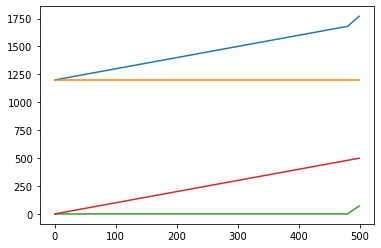

In [12]:
v = 4
N_F = 15
S_F  = 80

S_P = 15
c_f = 1

def C(N_F, S_F, D, v, S_P, c_f):
    return {'total':N_F * S_F + max(D/v- 8*N_F,0)*S_P + D*c_f,'fixed':N_F * S_F,'part':max(D/v- 8*N_F,0)*S_P,'fuel':D*c_f}
D_ls = np.arange(0,500,1)
cost_total_ls = [C(N_F, S_F, D, v, S_P, c_f)['total'] for D in D_ls]
cost_fixed_ls = [C(N_F, S_F, D, v, S_P, c_f)['fixed'] for D in D_ls]
cost_part_ls = [C(N_F, S_F, D, v, S_P, c_f)['part'] for D in D_ls]
cost_fuel_ls = [C(N_F, S_F, D, v, S_P, c_f)['fuel'] for D in D_ls]
plt.plot(D_ls, cost_total_ls)
plt.plot(D_ls, cost_fixed_ls)
plt.plot(D_ls, cost_part_ls)
plt.plot(D_ls, cost_fuel_ls)



In [13]:
# Value	Description
# 0	ROUTING_NOT_SOLVED: Problem not solved yet.
# 1	ROUTING_SUCCESS: Problem solved successfully.
# 2	ROUTING_FAIL: No solution found to the problem.
# 3	ROUTING_FAIL_TIMEOUT: Time limit reached before finding a solution.
# 4	ROUTING_INVALID: Model, model parameters, or flags are not valid.


# 正常情况

In [183]:
N_exper = 100

N_order_ls = np.random.normal(loc=50,scale=10,size=N_exper).astype(int)
dist_result_ls = []
cost_result_ls = []

with progressbar.ProgressBar(max_value=N_exper) as bar:
    for i in range(len(N_order_ls)):
        N_order = N_order_ls[i]
        bar.update(i)
        order_loc_ls = np.zeros((2,N_order))
        max_density = np.max(order_density)
        max_sample = 30000
        order_sampled = 0
        for i in range(max_sample):
            random_loc_x = np.random.rand()*x_len
            random_loc_y = np.random.rand()*y_len
            if order_density[int(random_loc_x), int(random_loc_y)]/max_density > np.random.rand():
                order_loc_ls[:,order_sampled] = [random_loc_x, random_loc_y]
                order_sampled += 1
                if order_sampled >= N_order:
                    break
        # print(order_sampled)
        assert order_sampled >= N_order

        order_demands = np.random.randint(5,10,size=N_order)

        data, routing, manager, solution = vrp_solve(order_loc_ls, depot_loc_ls, order_demands, capacity=200)

    

        # print('time consumed: '+str(time_end - time_start))
        # print("Solver status: ", routing.status())
        if routing.status() != 1:
            print('failed')
            continue


        total_distance = 0
        
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            route_distance = 0
            node_ls = []
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                node_ls.append(node_index)
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                        previous_index, index, vehicle_id)
            node_ls.append(manager.IndexToNode(index))
            
            
            total_distance += route_distance
            
            for i in range(N_depot):
                if i in node_ls:
                    depot_used = i

        # print('total distance: '+str(total_distance))
        # print('total cost: '+str(C(N_F, S_F, total_distance, v, S_P, c_f)))
        cost_result_ls.append(C(N_F, S_F, total_distance, v, S_P, c_f))
        dist_result_ls.append(total_distance)

100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32


In [184]:
cost_result_ls

[{'total': 2036.25, 'fixed': 1200, 'part': 281.25, 'fuel': 555},
 {'total': 1659, 'fixed': 1200, 'part': 0, 'fuel': 459},
 {'total': 1622, 'fixed': 1200, 'part': 0, 'fuel': 422},
 {'total': 2178.75, 'fixed': 1200, 'part': 393.75, 'fuel': 585},
 {'total': 1673, 'fixed': 1200, 'part': 0, 'fuel': 473},
 {'total': 1581, 'fixed': 1200, 'part': 0, 'fuel': 381},
 {'total': 1874.75, 'fixed': 1200, 'part': 153.75, 'fuel': 521},
 {'total': 2041.0, 'fixed': 1200, 'part': 285.0, 'fuel': 556},
 {'total': 1879.5, 'fixed': 1200, 'part': 157.5, 'fuel': 522},
 {'total': 2012.5, 'fixed': 1200, 'part': 262.5, 'fuel': 550},
 {'total': 1628, 'fixed': 1200, 'part': 0, 'fuel': 428},
 {'total': 1969.75, 'fixed': 1200, 'part': 228.75, 'fuel': 541},
 {'total': 1798.75, 'fixed': 1200, 'part': 93.75, 'fuel': 505},
 {'total': 1610, 'fixed': 1200, 'part': 0, 'fuel': 410},
 {'total': 1969.75, 'fixed': 1200, 'part': 228.75, 'fuel': 541},
 {'total': 1622, 'fixed': 1200, 'part': 0, 'fuel': 422},
 {'total': 1617, 'fixed

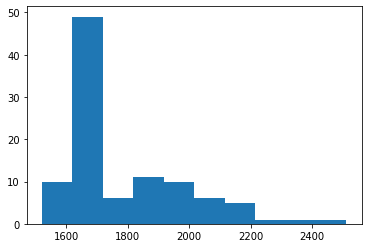

In [186]:
none = plt.hist(pd.DataFrame(cost_result_ls)['total'].values)

# 订单多了 随机筛选

In [242]:
N_total_order

110

In [243]:


# 每天订单数量(理论上来说这个应该是随机的，但是反正都肯定比50大，就直接设个100)
N_total_order_ls = np.random.normal(loc=100, scale=10*(2)**(1/2), size=N_exper).astype(int)
# 系统设定最多这么多
N_order_accept = 20
# 200个 3s
# 300个 7s
for N_order_accept in [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120]:
    dist_result_ls = []
    cost_result_ls = []
    accept_result_ls = []
    with progressbar.ProgressBar(max_value=N_exper) as bar:
        
        for i in range(N_exper):
            bar.update(i)
            N_total_order = N_total_order_ls[i]
            N_order = min(N_order_accept, N_total_order)
            order_loc_ls = np.zeros((2,N_total_order))
            max_density = np.max(order_density)
            max_sample = 300000
            order_sampled = 0
            for i in range(max_sample):
                random_loc_x = np.random.rand()*x_len
                random_loc_y = np.random.rand()*y_len
                if order_density[int(random_loc_x), int(random_loc_y)]/max_density > np.random.rand():
                    order_loc_ls[:,order_sampled] = [random_loc_x, random_loc_y]
                    order_sampled += 1
                    if order_sampled >= N_total_order:
                        break
            # print(order_sampled)
            assert order_sampled >= N_total_order
        
            order_demands = np.random.randint(5,10,size=N_total_order)
            
            saved_order = np.random.choice(N_total_order,N_order)
            saved_order_demands = order_demands[saved_order]
            saved_order_loc_ls = order_loc_ls[:,saved_order]


            data, routing, manager, solution = vrp_solve(saved_order_loc_ls, depot_loc_ls, saved_order_demands, capacity=200)

        

            # print('time consumed: '+str(time_end - time_start))
            # print("Solver status: ", routing.status())
            if routing.status() != 1:
                print('failed')
                continue


            total_distance = 0
            
            for vehicle_id in range(data['num_vehicles']):
                index = routing.Start(vehicle_id)
                route_distance = 0
                node_ls = []
                while not routing.IsEnd(index):
                    node_index = manager.IndexToNode(index)
                    node_ls.append(node_index)
                    previous_index = index
                    index = solution.Value(routing.NextVar(index))
                    route_distance += routing.GetArcCostForVehicle(
                            previous_index, index, vehicle_id)
                node_ls.append(manager.IndexToNode(index))
                
                
                total_distance += route_distance
                
                for i in range(N_depot):
                    if i in node_ls:
                        depot_used = i

            # print('total distance: '+str(total_distance))
            # print('total cost: '+str(C(N_F, S_F, total_distance, v, S_P, c_f)))
            cost_result_ls.append(C(N_F, S_F, total_distance, v, S_P, c_f))
            dist_result_ls.append(total_distance)
            accept_result_ls.append({'total_order':N_total_order, 'accepted_order':N_order})


    result_summary = {'cost':cost_result_ls, 'dist':dist_result_ls, 'accept_num':accept_result_ls}
    with open('result/current_strategy cost_result N_order_accepted:{} N_exper:{}.pkl'.format(N_order_accept, N_exper) ,'wb') as file:
        pkl.dump(result_summary, file)

100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (100 of 100) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
100% (100 of 100) |######################| Elapsed Time: 0:00:20 Time:  0:00:20
100% (100 of 100) |######################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (100 of 100) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (100 of 100) |######################| Elapsed Time: 0:00:31 Time:  0:00:31
100% (100 of 100) |######################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (100 of 100) |######################| Elapsed Time: 0:00:46 Time:  0:00:46
100% (100 of 100) |######################| Elapsed Time: 0:00:57 Time:  0:00:57
100% (100 of 100) |#####################

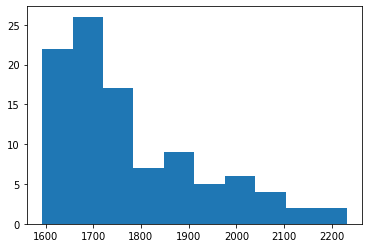

In [194]:
none = plt.hist(pd.DataFrame(cost_result_ls)['total'].values)

# 订单多了，接T_1天，拒绝T_2天，用T_1+T_2天配送

In [10]:
# bin packing problem

import cvxpy as cp

T_1T_2combi_ls = [[1,0],[2,0],[3,0],[1,1],[2,1],[3,1],[3,0],[3,1]]

T_1 = 2
T_2 = 0


# 200个 3s
# 300个 7s
# 400个 13s





# plt.scatter(order_loc_ls[0,:],order_loc_ls[1,:],s=1)
# plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')
# plt.xlim(0,x_len)
# plt.ylim(0,y_len);
N_exper = 10

cost_result_ls = []
dist_result_ls = []
route_result_ls = []
route_combo_result_ls = []

In [159]:
with progressbar.ProgressBar(max_value=N_exper) as bar:
    for i in range(N_exper):
        bar.update(i)

        N_order_each_day = np.random.normal(loc=100,scale=10*(2)**(1/2),size=T_1).astype(int)
        N_order_step1 = np.sum(N_order_each_day)    
       
        order_loc_ls = np.zeros((2,N_order_step1))
        max_density = np.max(order_density)
        max_sample = 30000
        order_sampled = 0
        for i in range(max_sample):
            random_loc_x = np.random.rand()*x_len
            random_loc_y = np.random.rand()*y_len
            if order_density[int(random_loc_x), int(random_loc_y)]/max_density > np.random.rand():
                order_loc_ls[:,order_sampled] = [random_loc_x, random_loc_y]
                order_sampled += 1
                if order_sampled >= N_order_step1:
                    break
        assert order_sampled == N_order_step1

        order_demands = np.random.randint(5,10,size=N_order_step1)
        # print(np.shape(order_loc_ls))

        data, routing, manager, solution = vrp_solve(order_loc_ls, depot_loc_ls, order_demands, capacity=200)


        # print('time consumed: '+str(time_end - time_start))
        # print("Solver status: ", routing.status())
        # print(N_order_step1)
        if routing.status() != 1:
            print('failed')
            continue


        total_distance = 0
        
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            route_distance = 0
            node_ls = []
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                node_ls.append(node_index)
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                        previous_index, index, vehicle_id)
            node_ls.append(manager.IndexToNode(index))
            
            
            total_distance += route_distance
            
            for i in range(N_depot):
                if i in node_ls:
                    depot_used = i

        # Step 2 ############################
        # vehicle_route: 每个vehicle走的route
        vehicle_route = {}

        for vehicle_id in range(data['num_vehicles']):
            this_vehicle_distance = 0
            this_vehicle_node_ls = []
            index = routing.Start(vehicle_id)
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                this_vehicle_node_ls.append(node_index)
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                this_vehicle_distance += routing.GetArcCostForVehicle(
                        previous_index, index, vehicle_id)
            this_vehicle_node_ls.append(manager.IndexToNode(index))
            if this_vehicle_distance != 0:
                vehicle_route[vehicle_id] = {'route':np.array(this_vehicle_node_ls), 'distance':this_vehicle_distance}

        n_route = len(vehicle_route)
        L_i = [vehicle_route[x]['distance'] for x in vehicle_route]



        y = cp.Variable((n_route,T_1+T_2),boolean=True)
        D_t = cp.Variable(T_1+T_2)
        C_t = cp.Variable(T_1+T_2)

        constraints = []
        for i in range(n_route):
            constraints.append(cp.sum(y[i,:]) == 1)

        for t in range(T_1+T_2):
            constraints.append(D_t[t] == cp.sum(y[:,t]*L_i))

        for t in range(T_1 + T_2):
            constraints.append(C_t[t] >= N_F*S_F + cp.maximum(0, (D_t[t]/v - 8*N_F))*S_P + D_t[t]*c_f)

        objective = cp.Minimize(cp.sum(C_t))
        prob = cp.Problem(objective, constraints)
        result = prob.solve()

        # for i in range(T_1+T_2):
        #     print('at day {} part time work for {}'.format(i, max(0, D_t.value[i]/v - 8*N_F)))
        # print('total cost: '+str(result))

        route_combo = {}
        for t in range(T_1+T_2):
            route_combo[t] = {'len_each_route':np.array(L_i)[np.where(y.value[:,t]==1)[0]],
                            'total_cost':C(N_F, S_F, np.sum(np.array(L_i)[np.where(y.value[:,t]==1)[0]]), v, S_P, c_f)}

        total_total = 0
        total_fixed = 0
        total_part = 0
        total_fuel = 0
        for i in range(len(route_combo)):
            total_total += route_combo[i]['total_cost']['total']
            total_fixed += route_combo[i]['total_cost']['fixed']
            total_part += route_combo[i]['total_cost']['part']
            total_fuel += route_combo[i]['total_cost']['fuel']
        route_combo['summary'] = {'total_total':total_total, 'total_fixed':total_fixed, 'total_part':total_part,'total_fuel':total_fuel}

        # print('total distance: '+str(total_distance))
        # print('total cost: '+str(C(N_F, S_F, total_distance, v, S_P, c_f)))
        cost_result_ls.append(result)
        dist_result_ls.append(total_distance)
        route_result_ls.append(vehicle_route)
        route_combo_result_ls.append(route_combo)
        
        # print(total_distance)

100% (10 of 10) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


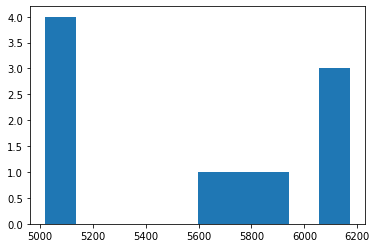

In [160]:
none = plt.hist(cost_result_ls)

In [161]:
route_combo_result_ls

[{0: {'len_each_route': array([63]),
   'total_cost': {'total': 863, 'fixed': 800, 'part': 0, 'fuel': 63}},
  1: {'len_each_route': array([ 55, 100, 330, 135, 191]),
   'total_cost': {'total': 4466.0,
    'fixed': 800,
    'part': 2854.9999999999995,
    'fuel': 811}},
  'summary': {'total_total': 5329.0,
   'total_fixed': 1600,
   'total_part': 2854.9999999999995,
   'total_fuel': 874}},
 {0: {'len_each_route': array([297]),
   'total_cost': {'total': 1382.0, 'fixed': 800, 'part': 285.0, 'fuel': 297}},
  1: {'len_each_route': array([ 85, 327, 128,  70, 202,  50]),
   'total_cost': {'total': 4772.0,
    'fixed': 800,
    'part': 3109.9999999999995,
    'fuel': 862}},
  'summary': {'total_total': 6154.0,
   'total_fixed': 1600,
   'total_part': 3394.9999999999995,
   'total_fuel': 1159}},
 {0: {'len_each_route': array([249]),
   'total_cost': {'total': 1094.0, 'fixed': 800, 'part': 45.0, 'fuel': 249}},
  1: {'len_each_route': array([163, 186, 116,  59, 110,  87]),
   'total_cost': {'tot